# Introduction

This notebook is the second in our project series and focuses on analyzing clients' credit history with the Home Credit Group. Specifically, we’ll explore the **"previous_applications.csv"** dataset, which contains detailed records of all previous credit applications made by our clients with the institution. Additionally, we’ll dive into three related monthly datasets that track payment and balance history for these previous applications:
* **POS_CASH_balance.csv:** Monthly records for point-of-sale and cash loan balances.
* **credit_card_balance.csv**: Monthly records for revolving credit card loans.
* **installments_payments.csv**: Monthly records for installment payments on previous loans.

These tables will allow us to analyze the payment behavior, balance changes, and other historical loan characteristics that could be useful in predicting clients’ credit risk.

## Dataset Overview

### Main Dataset
* **previous_applications.csv:**
     * **Number of samples**: 1,670,214
     * **Number of features**: 37
     * **Description**: This table contains detailed information on clients' past loan applications, with features describing both client attributes and loan characteristics. Some of these features overlap with those found in the primary applications.csv table.

### Supporting Monthly Datasets

Each of these datasets provides monthly-level details on various aspects of clients' previous loans.

* **POS_CASH_balance.csv:**
    * **Number of samples:** 10,001,358
    * **Description:** Contains information on point-of-sale and cash loan balances by month.
* **installments_payments.csv:**
    * **Number of samples:** 13,605,401
    * **Description:** Tracks monthly installment payments for previous loans, capturing details on payment schedules, amounts, and payment dates.
* **credit_card_balance.csv:**
    * **Number of samples:** 3,840,312
    * **Description:** Includes monthly balance and payment information for previous revolving credit card loans.
    
## Roadmap of the Analysis:
1. **Aggregate Supporting Tables to previous_applications.csv:**
    * Aggregate columns from monthly data tables (POS_CASH_balance.csv, credit_card_balance.csv, installments_payments.csv) to enrich the previous_applications.csv table with relevant features.
2. **Analyze Raw Data in previous_applications.csv:**
    * Treat Missing Data and Outliers: Address missing values and identify outliers for better data quality.
    * Univariate Analysis: Perform univariate analysis on each column to understand its distribution and potential impact.
3. **Aggregate Features to applications.csv:**
    * Transfer and aggregate relevant features from previous_applications.csv and supporting tables to applications.csv to build a more robust dataset for modeling.
4. **Analyze Feature Associations with Target Variable:**
    * Examine relationships between new features and the target variable to assess predictive potential and guide model-building.
    
## Conclusion from the Analysis of Features from Previous Applications

In total, we analyzed over **1.6 million previous applications**, with most of them containing historical data on loan situations across multiple months. While many columns had significant missing values, the final aggregated features provided valuable insights. A large proportion of applications were not approved. After aggregating the data on a client level, we derived the following key insights:

1. **Default Rate and Loan History**:
    * Past Loan History: Clients who have taken loans in the past tend to have a higher default rate compared to those without previous loans.
    * Number of Previous Applications: An increase in the average number of previous applications correlates with a higher chance of default. This suggests that frequent loan applicants may have financial difficulties leading to higher default rates.
2. **Impact of Unapproved Loans**
    * Clients who had unapproved loans in the past are more likely to default. This indicates that a history of loan rejection may be a strong negative predictor of future loan behavior.
3. **Ongoing Loans and Default Rates:**
    * Interestingly, clients with ongoing loans have a slightly lower chance of default. This may indicate that clients who are currently managing loans are more likely to continue managing their financial obligations responsibly.
4. **Type of Loan and Default Rates:**
    * Cash Loans and Revolving Loans: Having taken cash or revolving loans in the past was found to negatively affect the default rate. 
5. **Payment History as a Strong Predictor:**
    * Late Payments: Clients with a history of late payments show a higher likelihood of default. This suggests that payment behavior is a significant predictor of financial stability.
    * Underpaid Installments: Clients who paid less than the required minimum installment are also more likely to default in the future, emphasizing the importance of maintaining the agreed repayment schedule.
    * Exceeding Credit Limits: Clients who drew more money than their allowed limit on revolving loans are at a higher risk of default, indicating poor financial management.
6. **Interest Rates and Default Rate:**
    * Clients who took loans with higher interest rates in the past tend to have a higher default rate, which may indicate that higher-cost loans are associated with financially unstable clients.
7. **Days Past Due (DPD)**
    * People who defaulted tend to have more days past due in their previous loans. This reflects poor repayment behavior and suggests that clients with high DPD are more likely to default in the future.
8. **Average Drawn Amount**
    * Clients who drew more money on average from their loans are more likely to default. This may indicate that higher loan amounts are associated with clients who overextend themselves financially.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('..'))
from utils.preprocessing import helper_functions
from utils.feature_engineering import (create_features_from_previous_data,
                                       fill_unapproved_application_features,
                                        aggregate_client_level)

In [3]:
application = pd.read_csv("../datasets/application_train.csv")
previous_application = pd.read_csv("../datasets/previous_application.csv")
installments = pd.read_csv("../datasets/installments_payments.csv")
pos_cash = pd.read_csv("../datasets/POS_CASH_balance.csv")
credit_card = pd.read_csv("../datasets/credit_card_balance.csv")
application_test = pd.read_csv("../datasets/application_test.csv")

**How many applications are present in the behavioral tables:**

In [4]:
previous_application_ids = set(previous_application["SK_ID_PREV"].unique())
previous_application_revolving_ids = set(previous_application[
    previous_application["NAME_CONTRACT_TYPE"] == "Revolving loans"]["SK_ID_PREV"].unique())
installments_ids = set(installments["SK_ID_PREV"].unique()) 
pos_cash_ids = set(pos_cash["SK_ID_PREV"].unique())
credit_card_ids = set(credit_card["SK_ID_PREV"].unique())

In [5]:
print(f"Number of previous applications: {len(previous_application_ids)}")
print("Number of previous revolving applications: "
      f"{len(previous_application_revolving_ids)}")
print("Number of applications that are present in installments table: "
      f"{len(previous_application_ids.intersection(installments_ids))}")

print("Number of applications that are present in pos_cash table: "
      f"{len(previous_application_ids.intersection(pos_cash_ids))}")

print("Number of revolving applications that are present in credit_card_balance table: "
      f"{len(previous_application_revolving_ids.intersection(credit_card_ids))}")

Number of previous applications: 1670214
Number of previous revolving applications: 193164
Number of applications that are present in installments table: 958905
Number of applications that are present in pos_cash table: 898903
Number of revolving applications that are present in credit_card_balance table: 92935


There are more than 1.5 millions of applications. Almost 1 million of them is present in installments or pos_cash tables. Out of almost 200 thousands revolving applications, almost 100 thousand of them is present in credit_card table.

In [6]:
# extract only last applications for the previous contract
previous_application = (previous_application[
    previous_application["FLAG_LAST_APPL_PER_CONTRACT"] == "Y"])

## Aggregate Supporting Tables to previous_applications.csv:

**Features from POS_CASH_balance.csv table:**
* LOAN_LENGTH: The length of the loan
* IS_COMPLETED: Indicator of loan completion
* LAST_SNAPSHOT: Most recent occurence of the loan in the table
* HAD_DPD: Indicator of whether there was late payment during the contract
* INSTALLMENT_CHANGED: Indicator whether the number of installment changed during the contract
* AVERAGE_SNAPSHOT: Average months of balance 

**Features from installments.csv table:**
* VERSION_CHANGED: Marking 1 if the version of the loan changed during the contract.
* AVERAGE_INSTALLMENT: Average amount of installment.
* HAD_DPD: Marking 1 if there was occurence of a person paying later than the date specified.
* UNDERPAID: Marking 1 if there was occurence of a person paying less than minimum required.
* INSTALLMENT_COUNT: Calculate number of installments.

**Features from credit_card_balance:**
* IS_COMPLETED: Indicator of whether the loan is completed.
* LAST_SNAPSHOT: Most recent occurence of the loan in the table.
* AVERAGE_SNAPSHOT: Average months of balance.
* HAD_DPD: Indicator of whether there was late payment during the contract.
* AVG_DRAWINGS: Average amount of drawings.
* EXCEEDED_LIMIT: Mark 1 if the amount of drawings exceeded limit amount at least once.
* UNDERPAID: Mark 1 if the amount of payment was less then minimum required.

In [7]:
previous_application = create_features_from_previous_data(pos_cash, 
                                                          installments, 
                                                          credit_card, 
                                                          previous_application)

Now, we have all of the columns in previous_application table.

## Analysing the columns in "previous_applications.csv" table

Check values of categorical columns:

In [8]:
helper_functions.print_unique_values_for_cat_columns(previous_application)

---------------------------------------------
NAME_CONTRACT_TYPE
['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']
---------------------------------------------
WEEKDAY_APPR_PROCESS_START
['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']
---------------------------------------------
FLAG_LAST_APPL_PER_CONTRACT
['Y']
---------------------------------------------
NAME_CASH_LOAN_PURPOSE
['XAP' 'XNA' 'Repairs' 'Everyday expenses' 'Car repairs'
 'Building a house or an annex' 'Other' 'Journey'
 'Purchase of electronic equipment' 'Medicine' 'Payments on other loans'
 'Urgent needs' 'Buying a used car' 'Buying a new car'
 'Buying a holiday home / land' 'Education' 'Buying a home' 'Furniture'
 'Buying a garage' 'Business development' 'Wedding / gift / holiday'
 'Hobby' 'Gasification / water supply' 'Refusal to name the goal'
 'Money for a third person']
---------------------------------------------
NAME_CONTRACT_STATUS
['Approved' 'Refused' 'Canceled' 'Unused offer

In some columns, missing values are marked differentlly. Let's mark all as np.nan

In [9]:
previous_application.loc[previous_application["SELLERPLACE_AREA"] == -1, 
                         "SELLERPLACE_AREA"] = np.nan
previous_application.replace({"XAP": np.nan}, inplace=True)
previous_application.replace({"XNA": np.nan}, inplace=True)

Check numeric columns:

In [10]:
int_cols = ["DAYS_DECISION", "NFLAG_LAST_APPL_IN_DAY"]
num_cols = list(previous_application.select_dtypes("float64")) + int_cols
previous_application[num_cols].describe()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,SELLERPLACE_AREA,CNT_PAYMENT,...,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AVERAGE_INSTALLMENT,INSTALLMENT_COUNT,LOAN_LENGTH,AVG_DRAWINGS,LAST_SNAPSHOT,AVERAGE_SNAPSHOT,DAYS_DECISION,NFLAG_LAST_APPL_IN_DAY
count,1.289508e+06,1.661739e+06,1.661738e+06,7.743690e+05,1.281237e+06,774369.000000,5951.000000,5951.000000,9.031880e+05,1.289513e+06,...,997149.000000,997149.000000,9.589050e+05,958905.000000,898903.000000,9.293500e+04,991838.000000,991838.000000,1.661739e+06,1.661739e+06
mean,1.597907e+04,1.753872e+05,1.954724e+05,6.697411e+03,2.274737e+05,0.079637,0.188357,0.773503,5.797228e+02,1.615936e+01,...,81992.343838,0.332570,2.643169e+04,12.884045,13.017144,1.498218e+04,-25.316627,-31.080345,-8.793741e+02,9.995270e-01
std,1.480483e+04,2.930528e+05,3.188173e+05,2.092151e+04,3.154937e+05,0.107823,0.087671,0.100879,9.684183e+03,1.455646e+01,...,153303.516729,0.471134,6.431556e+04,14.677192,9.685155,2.779867e+04,25.315087,24.951533,7.778460e+02,2.174339e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,-0.000015,0.034781,0.373150,0.000000e+00,0.000000e+00,...,-2874.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000e+00,-94.000000,-95.000000,-2.922000e+03,0.000000e+00
25%,6.330780e+03,1.918800e+04,2.389500e+04,0.000000e+00,5.072850e+04,0.000000,0.160716,0.715645,2.500000e+01,6.000000e+00,...,-1270.000000,0.000000,6.709286e+03,6.000000,7.000000,0.000000e+00,-42.000000,-47.000000,-1.298000e+03,1.000000e+00
50%,1.125000e+04,7.124400e+04,7.959150e+04,1.638000e+03,1.118070e+05,0.051606,0.189122,0.835095,6.500000e+01,1.200000e+01,...,-499.000000,0.000000,1.204239e+04,10.000000,11.000000,4.447674e+03,-16.000000,-23.000000,-5.800000e+02,1.000000e+00
75%,2.067594e+04,1.800000e+05,2.156400e+05,7.740000e+03,2.314890e+05,0.108909,0.193330,0.852537,3.520000e+02,2.400000e+01,...,-44.000000,1.000000,2.356420e+04,14.000000,13.000000,2.029325e+04,-2.000000,-10.500000,-2.800000e+02,1.000000e+00
max,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,1.000000,1.000000,1.000000,4.000000e+06,8.400000e+01,...,365243.000000,1.000000,3.202062e+06,293.000000,96.000000,1.616206e+06,-1.000000,-1.000000,-1.000000e+00,1.000000e+00


* Values, where down payment is < 0 will be marked as np.nan
* Date columns which have 365243 values, will also be marked as np.nan

In [11]:
previous_application.loc[previous_application["AMT_DOWN_PAYMENT"] < 0, 
                         ["AMT_DOWN_PAYMENT", "RATE_DOWN_PAYMENT"]] = np.nan
date_columns = ["DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", 
               "DAYS_LAST_DUE", "DAYS_TERMINATION", "DAYS_FIRST_DRAWING"]
for column in date_columns:
    previous_application.loc[previous_application[column] == 365243, 
                             column] = np.nan

Check of missing data

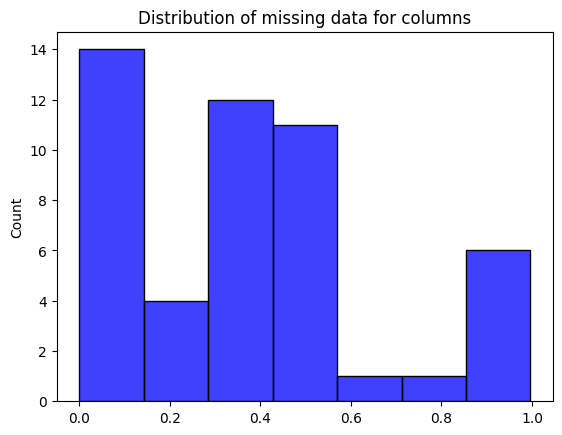

In [12]:
missing_pct = previous_application.isnull().sum() / len(previous_application)
sns.histplot(missing_pct, color="blue")
plt.title("Distribution of missing data for columns");

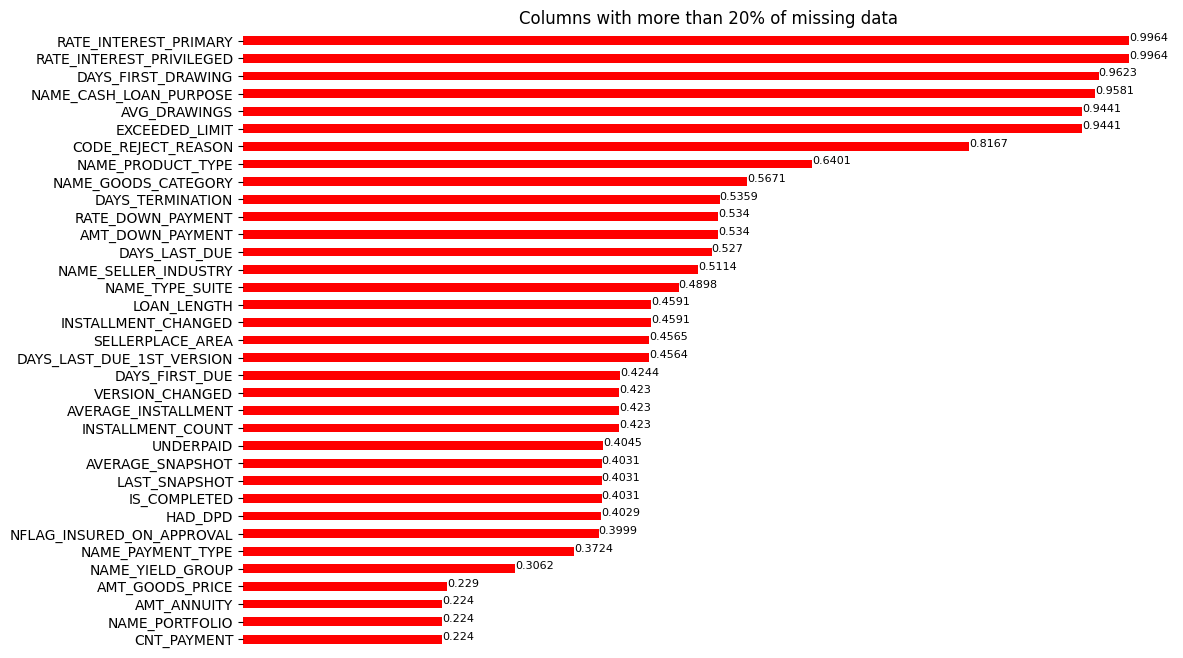

In [14]:
plt.figure(figsize=(12, 8))
most_missing_data = missing_pct[missing_pct > 0.2]
most_missing_data.sort_values(ascending=True).plot(kind="barh", color="red")
ax = plt.gca()
helper_functions.customize_bar(position="h", axes=ax, round_to=4, values_font=8)
plt.title("Columns with more than 20% of missing data");

Columns from behavioral tables have a lot of missing data, which is not suprising, as some applications are absent in those tables. However, there are some original columns from previous_application table with more than 90% of missing data. We will drop the following columns:

In [15]:
previous_application.drop(columns=["RATE_INTEREST_PRIMARY",
                                   "RATE_INTEREST_PRIVILEGED",
                                  "NAME_CASH_LOAN_PURPOSE",
                                  "DAYS_FIRST_DRAWING"],
                         inplace=True)

Count of missing values by row:

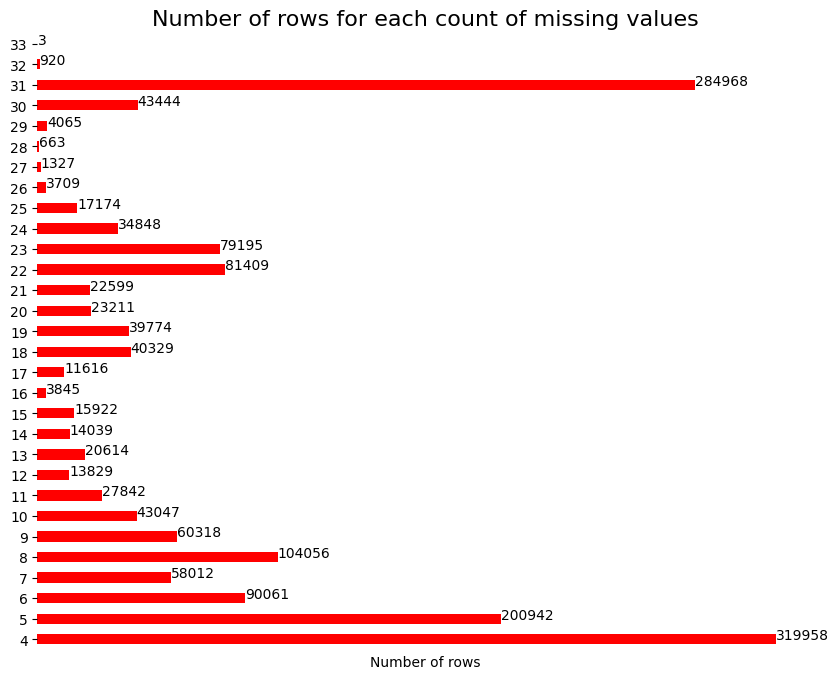

In [17]:
helper_functions.plot_missing_values_by_row(previous_application,
                                           figsize=(10, 8));

There are no rows with all missing data. Each row still preserves some information. A lot of rows have 31 missing columns. These rows have 0 amount of credit and are usually not approved. That is the reason for so much missing cells in them

Mark np.nan as "UNKNOWN" in categorical columns for the EDA.

In [18]:
cat_columns = list(previous_application.select_dtypes("object").columns)
previous_application[cat_columns] = (previous_application[cat_columns].fillna("UNKNOWN"))

## Analysis of the columns in previous_application table

We will start with categorical columns, that are original in previous_application table:

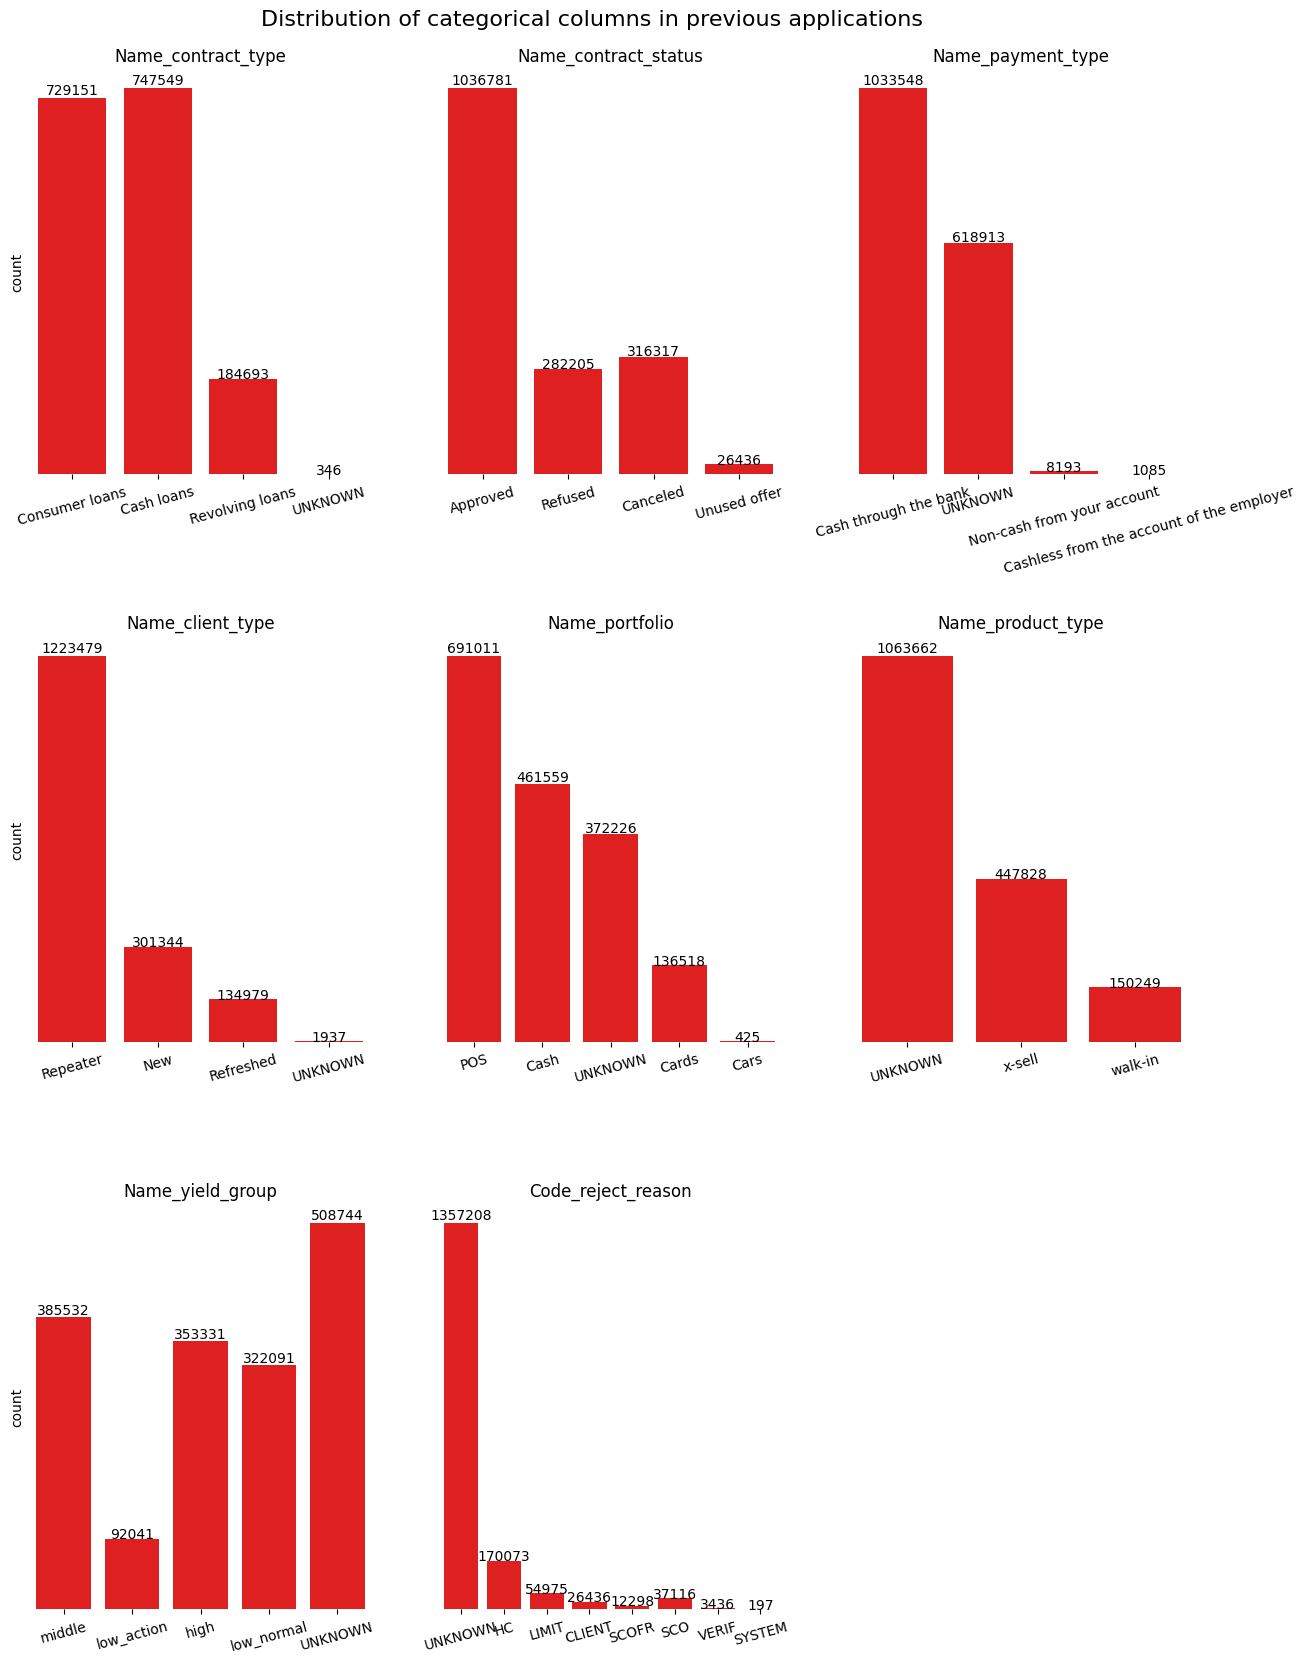

In [19]:
cat_columns = ["NAME_CONTRACT_TYPE", "NAME_CONTRACT_STATUS", 
               "NAME_PAYMENT_TYPE", "NAME_CLIENT_TYPE", 
               "NAME_PORTFOLIO", "NAME_PRODUCT_TYPE", 
               "NAME_YIELD_GROUP", "CODE_REJECT_REASON"]
title = "Distribution of categorical columns in previous applications"
helper_functions.plot_cat_columns(previous_application, cat_columns, col_number=3,
                                  title=title, figsize=(15, 20), rotate=15);

We have a big portion of applications that weren't approved. There are consumer, cash or revolving loans. In a lot of other columns, majority of the values are missing.

Missing values in Reason of rejection feature are only for approved loans.
Missing data for grouped interest rate is for unapproved or revolving loans.


Encode grouped interest rate into a numeric feature and turn to numeric type

In [20]:
pd.set_option('future.no_silent_downcasting', True)
previous_application["NAME_YIELD_GROUP"] = (previous_application
                                            ["NAME_YIELD_GROUP"]
                                            .replace({"low_action": 1,
                                                      "low_normal": 2,
                                                      "middle": 3,
                                                      "high": 4,
                                                      "UNKNOWN": np.nan}))

previous_application["NAME_YIELD_GROUP"] = (previous_application
                                            ["NAME_YIELD_GROUP"].astype(float))

Now, let's dig into categorical columns, that came from behavioral tables:

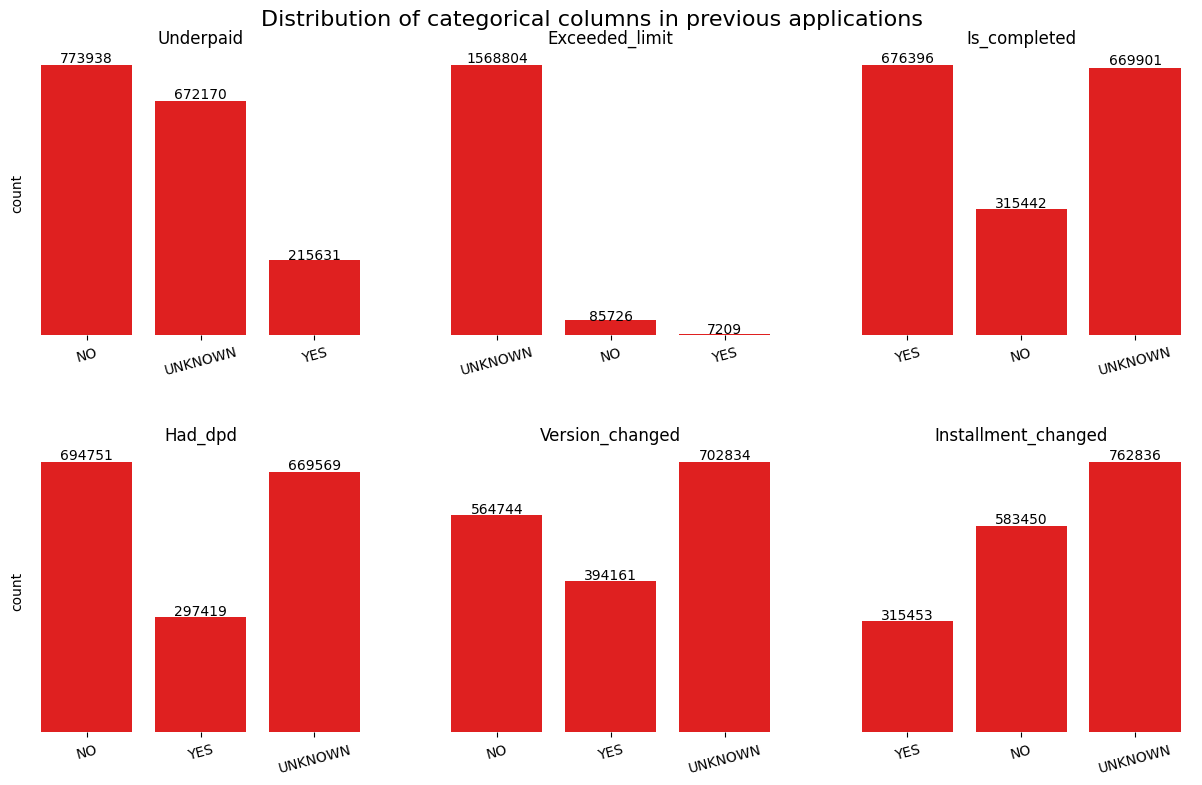

In [21]:
agg_cat_cols = ["UNDERPAID", "EXCEEDED_LIMIT", "IS_COMPLETED", 
                "HAD_DPD", "VERSION_CHANGED", "INSTALLMENT_CHANGED"]
helper_functions.plot_cat_columns(previous_application, agg_cat_cols, col_number=3,
                                  title=title, figsize=(15, 14), rotate=15);

We have around 300 thousands of ongoing applications. There are also a lot of instances when a client paid late or had their version of the calendar changed.

**Numerical columns**:

There are 336764 applications with zero in credit amount. Most of them are unapproved. Those applications, which are approved are revolving. This could mean that either the clients haven't used their card or the balance is 0 there.

Correlation of numeric features

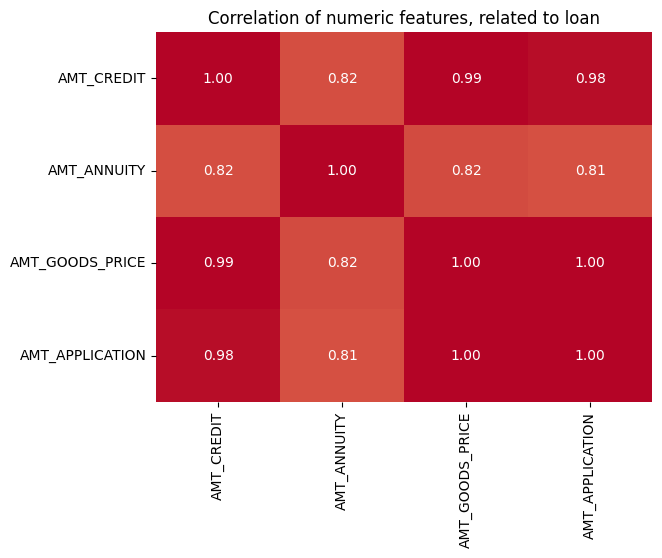

In [23]:
loan_num = ["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "AMT_APPLICATION"]
corr = previous_application[loan_num].corr()
plt.title("Correlation of numeric features, related to loan")
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", 
            vmin=-1, vmax=1, cbar=None);

All of the loan numeric features are strongly correlated with each other. Therefore, we will keep only 2 of them:
* AMT_CREDIT
* AMT_ANNUITY

In addition to that, we will analyze our newly created columns:
* AVERAGE_INSTALLMENT
* AVG_DRAWINGS

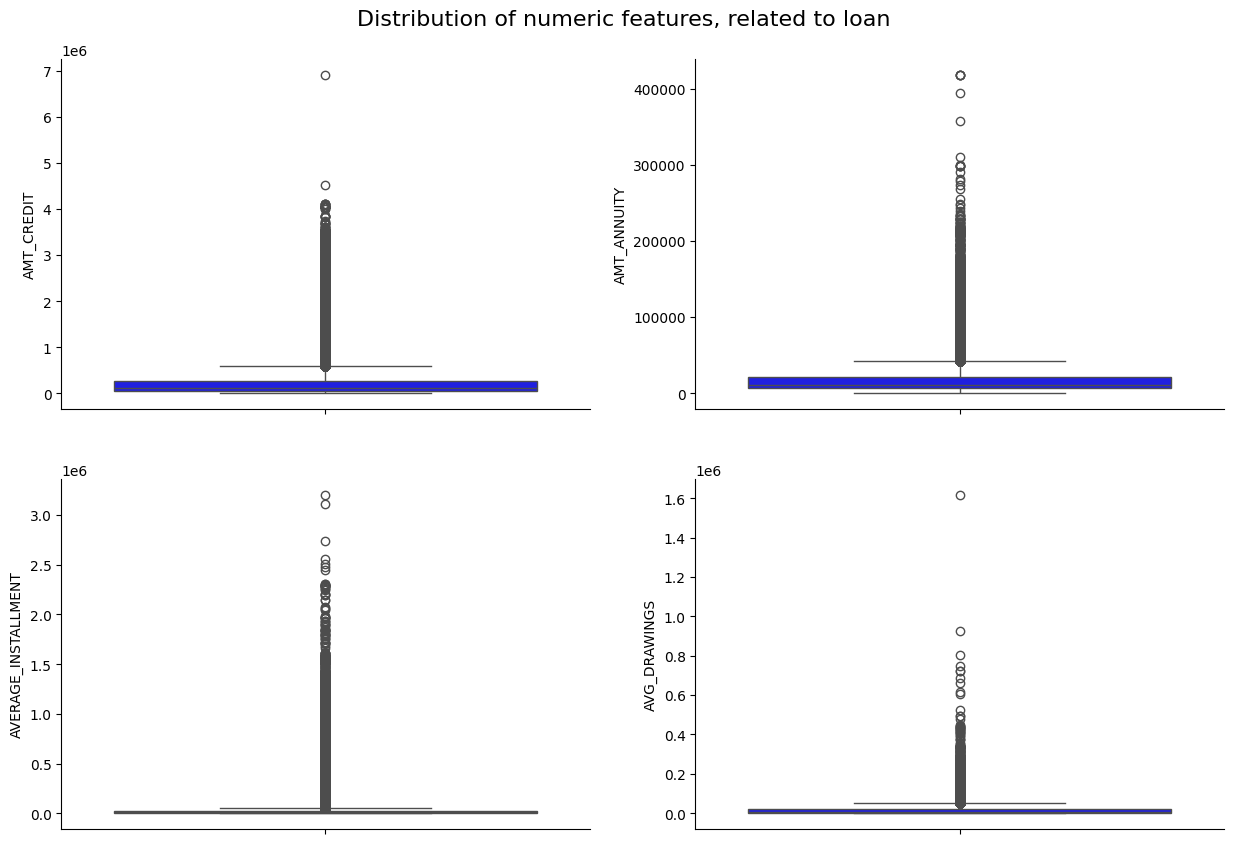

In [24]:
data_to_plot = previous_application[previous_application["AMT_CREDIT"] != 0]
loan_num = ["AMT_CREDIT", "AMT_ANNUITY", "AVERAGE_INSTALLMENT", "AVG_DRAWINGS"]
helper_functions.plot_num_dist(columns=loan_num, data=data_to_plot, 
                               figsize=(15, 10), plot_type="box",
                               title="Distribution of numeric features, related to loan")

All of the distributions are highly right-skewed.

Almost all of the rows with missing annuity are not approved. Majoirity of them have zero in credit amount too. We can mark all these values as 0.

In [25]:
previous_application.loc[previous_application["AMT_ANNUITY"].isnull(), "AMT_ANNUITY"] = 0
previous_application.loc[previous_application["AMT_CREDIT"].isnull(), "AMT_CREDIT"] = 0

Columns, related to down payment:

Down payment is either missing for both columns(normalized and not) or for none.

Where credit amount is 0 or the loan is unapproved, mark down payment as 0.

In [26]:
unappr_mask = previous_application["NAME_CONTRACT_STATUS"] != "Approved"
down_payment_null = previous_application["RATE_DOWN_PAYMENT"].isnull()
credit_zero_mask = (previous_application["AMT_CREDIT"] == 0)

previous_application.loc[(down_payment_null) & (credit_zero_mask), 
                         ["RATE_DOWN_PAYMENT", "AMT_DOWN_PAYMENT"]] = 0
previous_application.loc[(down_payment_null) & (unappr_mask), 
                         ["RATE_DOWN_PAYMENT", "AMT_DOWN_PAYMENT"]] = 0

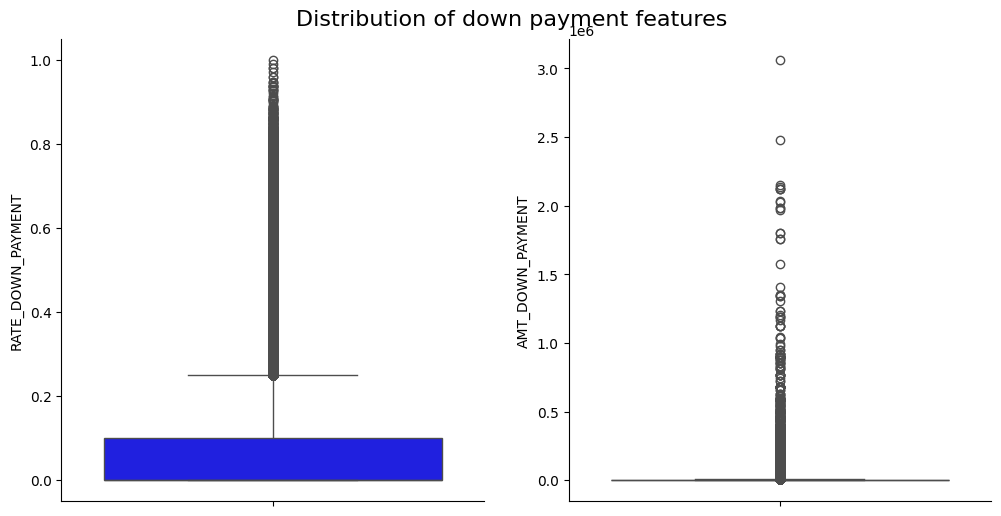

In [28]:
down_payment_cols = ["RATE_DOWN_PAYMENT", "AMT_DOWN_PAYMENT"]
helper_functions.plot_num_dist(columns=down_payment_cols, data=previous_application, 
                               figsize=(12, 6), plot_type="box",
                               title="Distribution of down payment features")

Amount of down payment is highly skewed. Normalized version has a better skewness.

Let's analyze time related columns

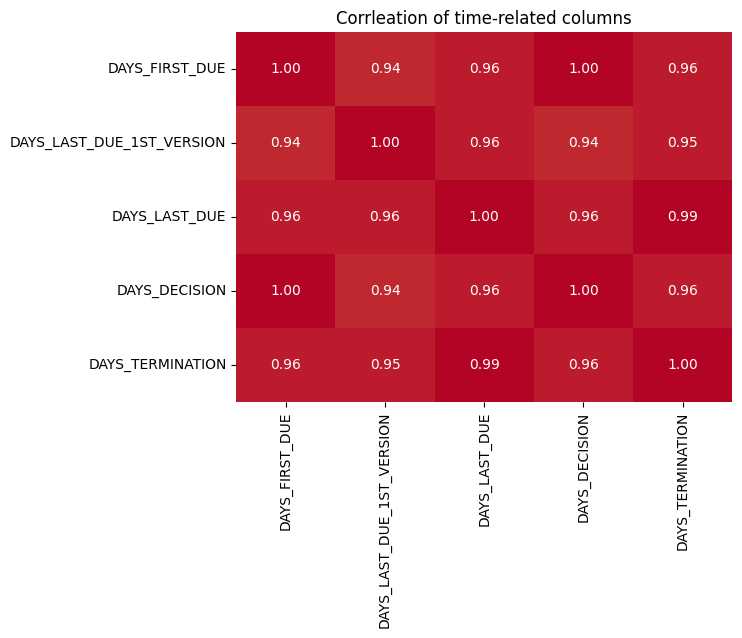

In [29]:
time_columns = ["DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE"]
start_end = ["DAYS_DECISION", "DAYS_TERMINATION"]
corr = previous_application[time_columns + start_end].corr()
plt.title("Corrleation of time-related columns")
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
           vmin=-1, vmax=1, cbar=None);

All of the columns are almost perfectly correlated. There is no point in keeping all of them. Considering a lot of missing data in the following columns: DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE; we will drop them. We will keep DAYS_DECISION and DAYS_TERMINATION for now.

In [30]:
previous_application.drop(columns=["DAYS_FIRST_DUE", 
                                   "DAYS_LAST_DUE_1ST_VERSION",
                                   "DAYS_LAST_DUE"], inplace=True)

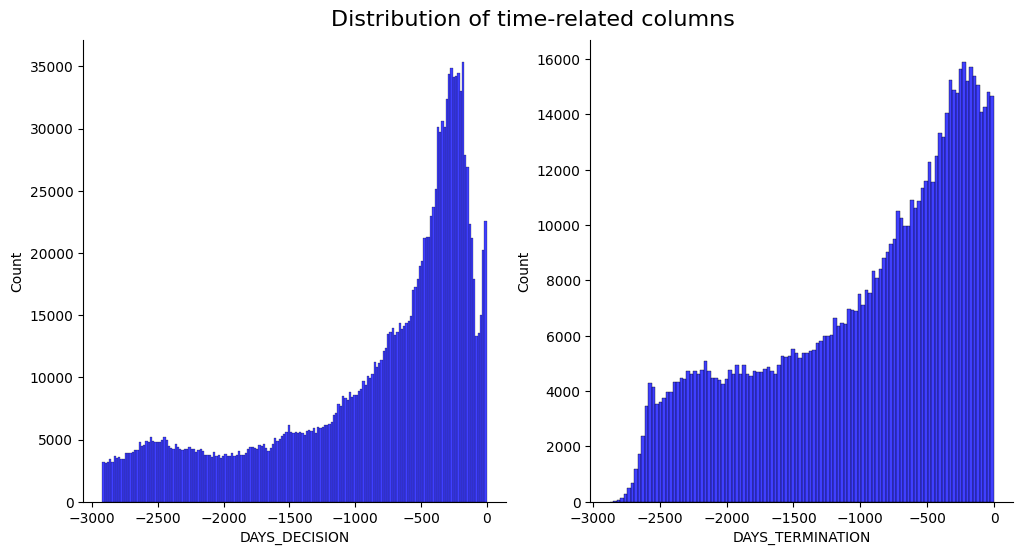

In [31]:
title = "Distribution of time-related columns"
helper_functions.plot_num_dist(columns=start_end, data=previous_application, 
                               figsize=(12, 6), plot_type="hist",
                               title=title);

Regarding the spike in column about the decision of application, most of the applications there are cancelled or refused. Almost all of the rows miss data in day of termination of the contract and day due of the application. For approved applications, which are recent, the day of termination haven't been yet. For unapproved applications, the day of termination is missing(should be marked as the day of decision).

Now, let's dig into columns, that are related to loan duration and payment structure:

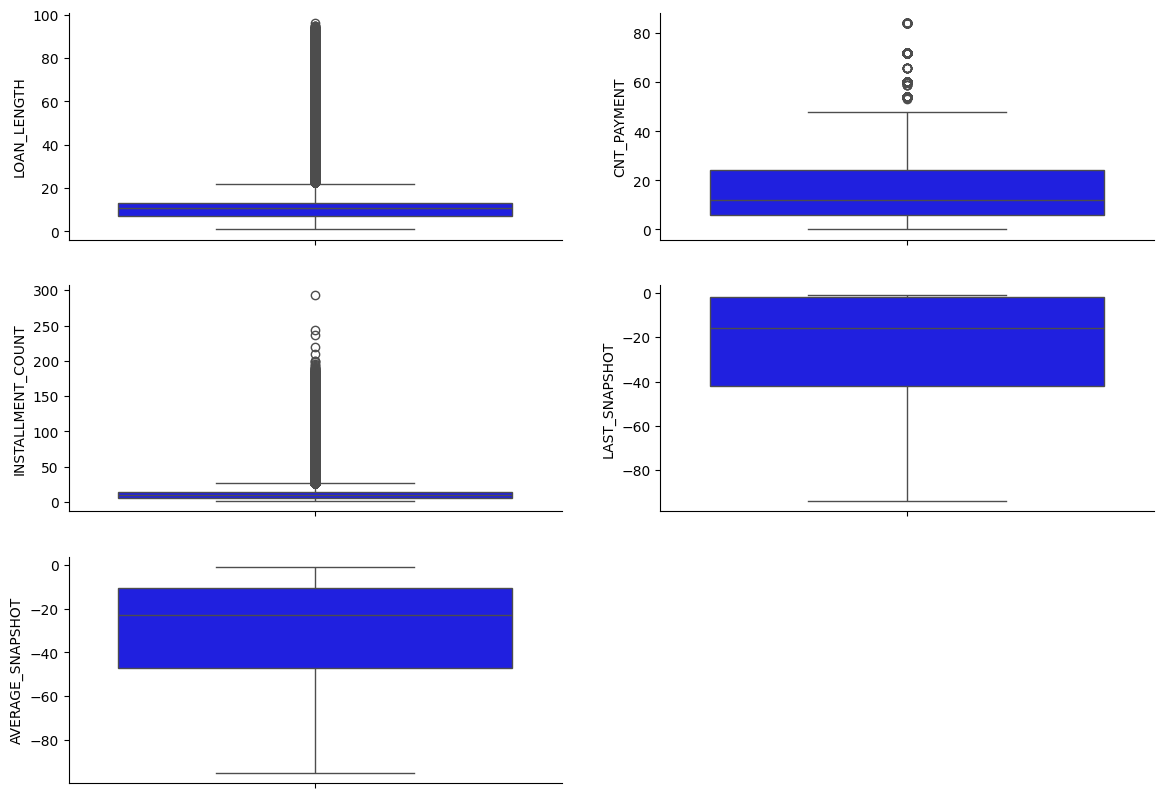

In [32]:
dur_str_cols = ["LOAN_LENGTH", "CNT_PAYMENT", 
                "INSTALLMENT_COUNT", "LAST_SNAPSHOT", "AVERAGE_SNAPSHOT"]
title = "Box plot of columns, related to loan duration and payment structure"
helper_functions.plot_num_dist(columns=dur_str_cols, data=previous_application, 
                               figsize=(14, 10), plot_type="box",
                               title="");

The length of the loan has a lot of outliers. There are some loans which lasted up to 100 months. Most of the applications have their last snapshot in recent time.

Usually, there is history about applications up to 80 months ago

**Filling in missing data**

For some of columns, there is pattern in their missing values. We will do imputation of these values.

* For IS_COMPLETED columns: mark it as "YES" if we have unapproved contract
* For INSTALLMENT_COUNT column, mark 0 if the we have unapproved contract
* For CNT_PAYMENT column, mark 0 if we have unapproved contract
* For LOAN_LENGTH column: 
    * mark 0 if we have unapproved contract
    * calculate difference between day of termination and day of creation of the contract. Fill miss data.

In [40]:
previous_application = fill_unapproved_application_features(previous_application)

## Aggregate Features to applications.csv:

We are going to create the following features for our main applications table:
* APPLICATION_COUNT_PREV: count of previous applications per each client
* HAS_NON_APPROVED_PREV: indicator of whether a person has ever had an unapproved loan
* HAD_CONSUMER_LOAN_PREV: indicator of whether a person has ever had a consumer loan
* HAD_REVOLVING_LOAN_PREV: indicator of whether a person has ever had a revolving loan
* HAD_CASH_LOAN_PREV: indicator of whether a person has ever had a cash loan
* HAD_X_SELL_PREV: indicator of whether a person has ever had an x-sell loan
* HAS_ONGOING_LOAN_PREV: indicator of whether a person has a current loan
* HAD_DPD_PREV: indicator of whether a person has ever had a late payment
* VERSION_CHANGED_PREV: indicator of whether a person has ever had version changed in their contract
* LIMIT_EXCEEDED_PREV: indicator of whether a person has ever exceeded limit in their contract
* UNDERPAID_PREV: indicator of whether a person has ever underpaid in their contract
* INSTALLMENTS_OVER_CNT_PAYMENT_PREV: indicator of whether a person had more instalments than planned
* AVERAGE_YIELD_GROUP_PREV: average interest rate per application
* AVERAGE_LOAN_LENGTH_PREV: average length of the loan
* AVERAGE_CNT_PAYMENT_PREV: average number of planned payments
* LAST_SNAPSHOT_MAX_PREV: the last occurence of the client's history
* LAST_SNAPSHOT_MEAN_PREV: average of the last occurences of the client's applications
* DAYS_DECISION_MEAN_PREV: average of days of created applications
* DAYS_DECISION_MAX_PREV: the day of the most recent created application
* INSTALLMENT_COUNT_MEAN_PREV: average number of installments per application
* AVERAGE_AMT_CREDIT_PREV: average amount of credit per application
* AVERAGE_RATE_DOWN_PAYMENT_PREV: average rate down payment per application

In addition, to not lose granulity, some averages from behavioral data will be created by grouping in those tables:
* AVERAGE_DRAWINGS_PREV: average drawings per application
* AVERAGE_INSTALLMENT_PREV: average size of installment
* AVG_MONTHS_BALANCE: average months of history for the client
* DPD_COUNT: sum of days past dues

In [43]:
agg_prev = aggregate_client_level(previous_application, pos_cash, 
                                  credit_card, installments)

## Analyze Feature Associations with Target Variable

In [45]:
# add target variable to the table
application_agg = application[["SK_ID_CURR", "TARGET"]].merge(agg_prev,
                                                              on="SK_ID_CURR", 
                                                              how="left")
# fill missing data in categorical columns with "UNKNOWN"
cat_columns = list(application_agg.select_dtypes("object").columns)
application_agg[cat_columns] = (application_agg[cat_columns].fillna("UNKNOWN"))

**Is there difference in the default chance between people with 0 previous applications and those, who had some previous applications?**

In [46]:
null_count = application_agg.loc[application_agg["APPLICATION_COUNT_PREV"].isnull()]
non_null_count = application_agg.loc[application_agg["APPLICATION_COUNT_PREV"].notnull()]
print("Average default chance for people, who don't have preivous application: "
     f"{null_count['TARGET'].mean()}")
print("Average default chance for people, who have preivous application: "
     f"{non_null_count['TARGET'].mean()}")

Average default chance for people, who don't have preivous application: 0.05955998541388112
Average default chance for people, who have preivous application: 0.08192553348656792


We see that clients, who have a previous application, have a higher percent of default.

**Association between number of previous applications and the chance of default?**

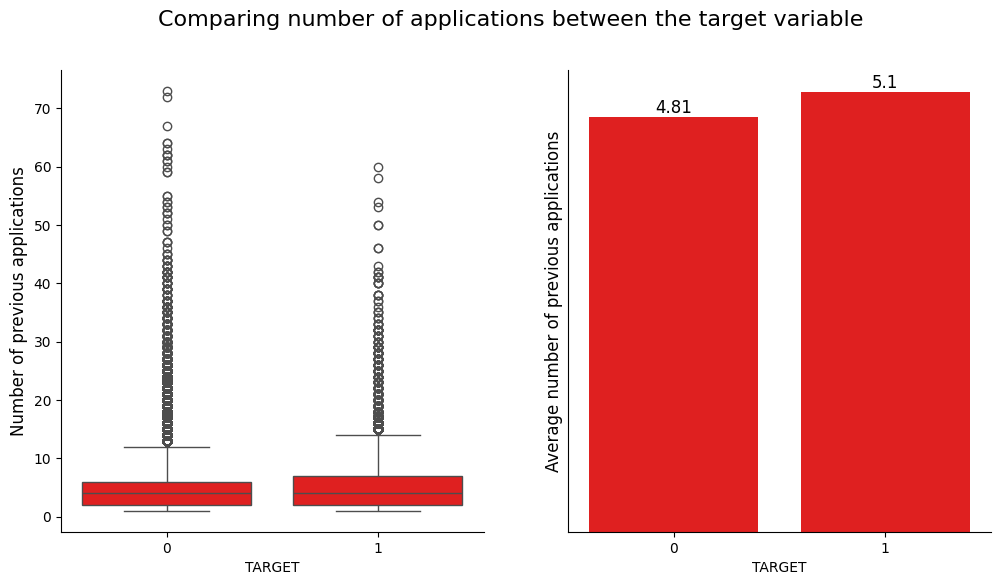

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("Comparing number of applications between the target variable",
            fontsize=16)
sns.boxplot(data=application_agg, y="APPLICATION_COUNT_PREV", 
            x="TARGET", ax=ax[0], color="red")
sns.barplot(data=application_agg, y="APPLICATION_COUNT_PREV", 
            x="TARGET", ax=ax[1], color="red", errorbar=None)
helper_functions.customize_bar(axes=ax[1], position="v", round_to=2)
sns.despine()
ax[0].set_ylabel("Number of previous applications", fontsize=12)
ax[1].set_ylabel("Average number of previous applications", fontsize=12);

Regarding number of applications, there are a lot of outliers with up to 70 applications. Some of them defaulted, some didn't. Average number of applications is a bit higher for defaulted people.

**Association between having unapproved loan, ongoing loan and the chance of default**

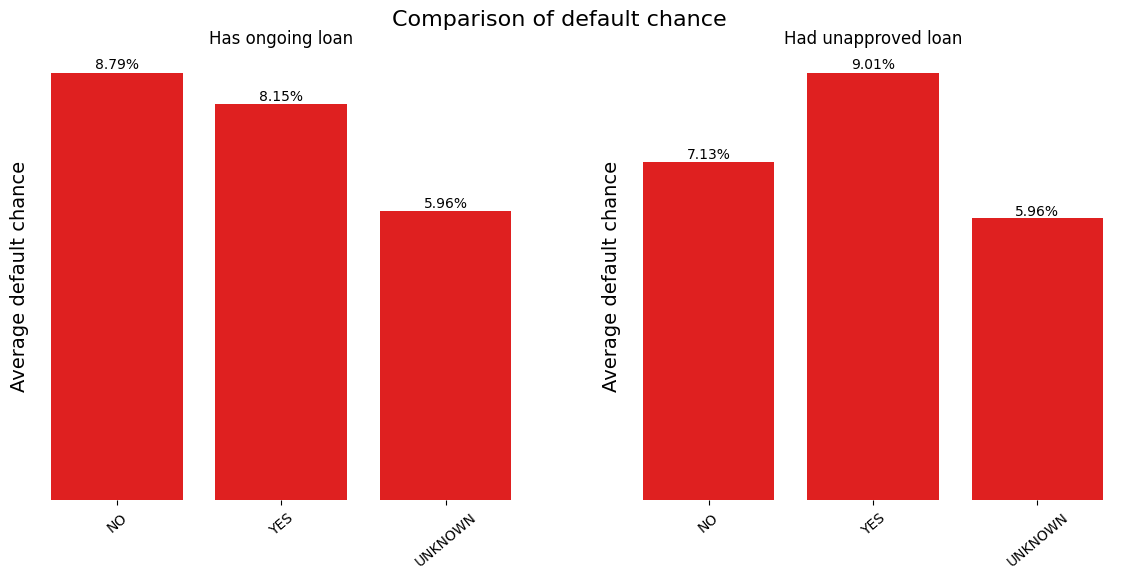

In [51]:
cols = ["HAS_ONGOING_LOAN_PREV", "HAD_NON_APPROVED_PREV"]
title = "Comparison of default chance"
fig, plt = helper_functions.plot_cat_columns(application_agg, cols, col_number=2,
                                   title=title, figsize=(14, 14), rotate=40, 
                                   target="TARGET")
ax0, ax1 = fig.get_axes()
ax0.set_title("Has ongoing loan")
ax1.set_title("Had unapproved loan")
for axes in ax0, ax1:
    axes.set_ylabel("Average default chance", fontsize=14)

The above bar plots indicate to us that having unapproved loan in the past negatively affects the chance of default. Those, who have an ongoing loan have a lower percent of default.

**Checking the default rate between having different type of loans in the past**

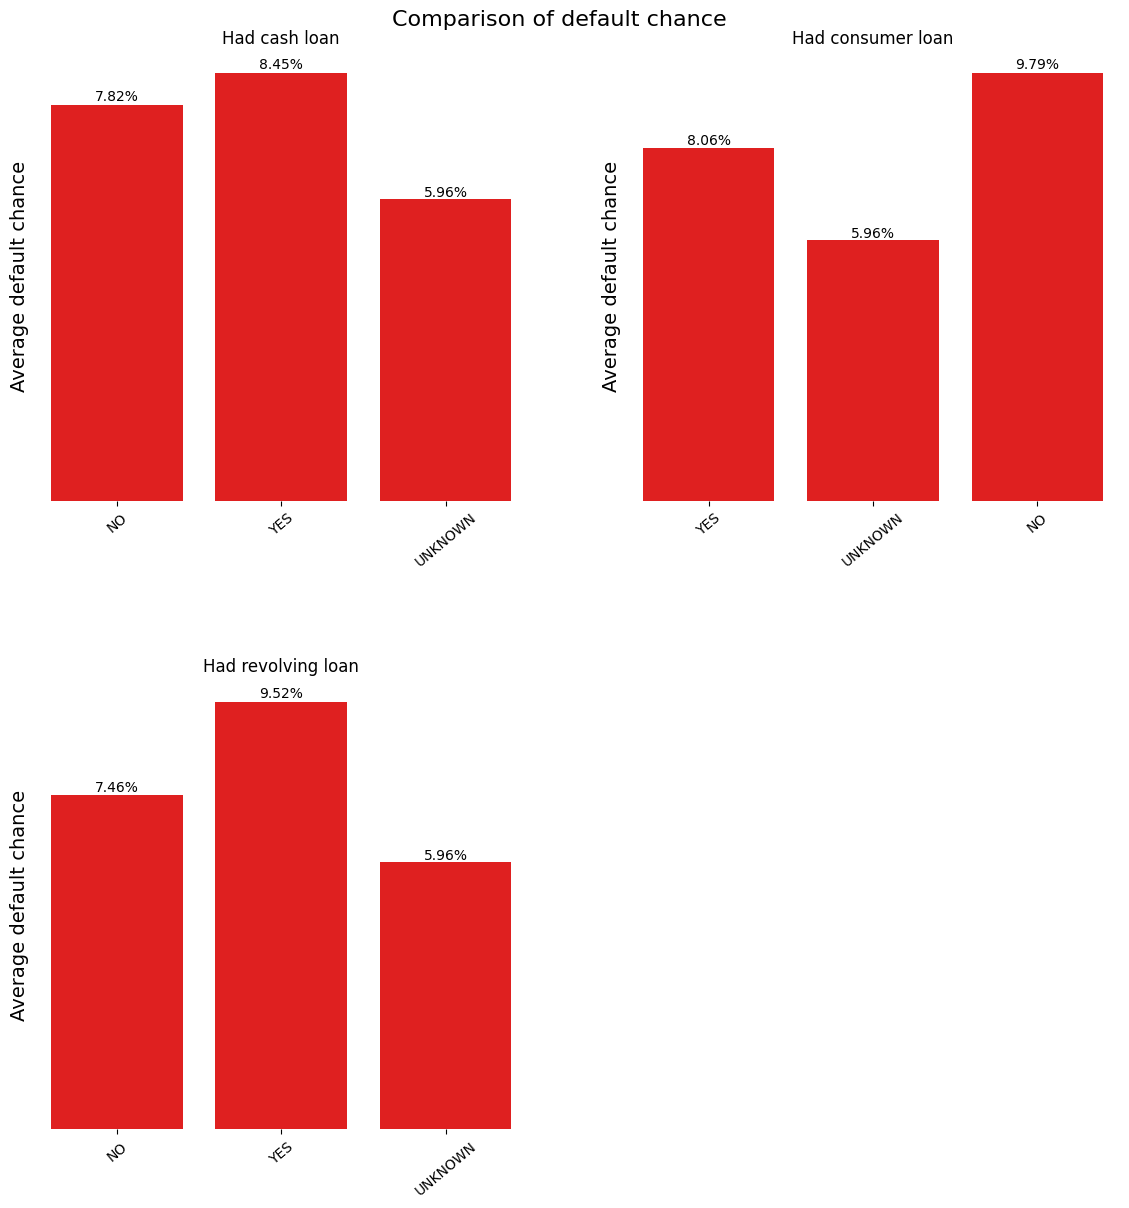

In [53]:
cols = ["HAD_CASH_LOAN_PREV", "HAD_CONSUMER_LOAN_PREV", "HAD_REVOLVING_LOAN_PREV"]
title = "Comparison of default chance"
fig, plt = helper_functions.plot_cat_columns(application_agg, cols, col_number=2,
                                   title=title, figsize=(14, 14), rotate=40, 
                                   target="TARGET")
ax0, ax1, ax2 = fig.get_axes()
ax0.set_title("Had cash loan")
ax1.set_title("Had consumer loan")
ax2.set_title("Had revolving loan")
for axes in ax0, ax1, ax2:
    axes.set_ylabel("Average default chance", fontsize=14)

Interestingly, those, who took revolving or cash loan in the past, have a higher percent of default.

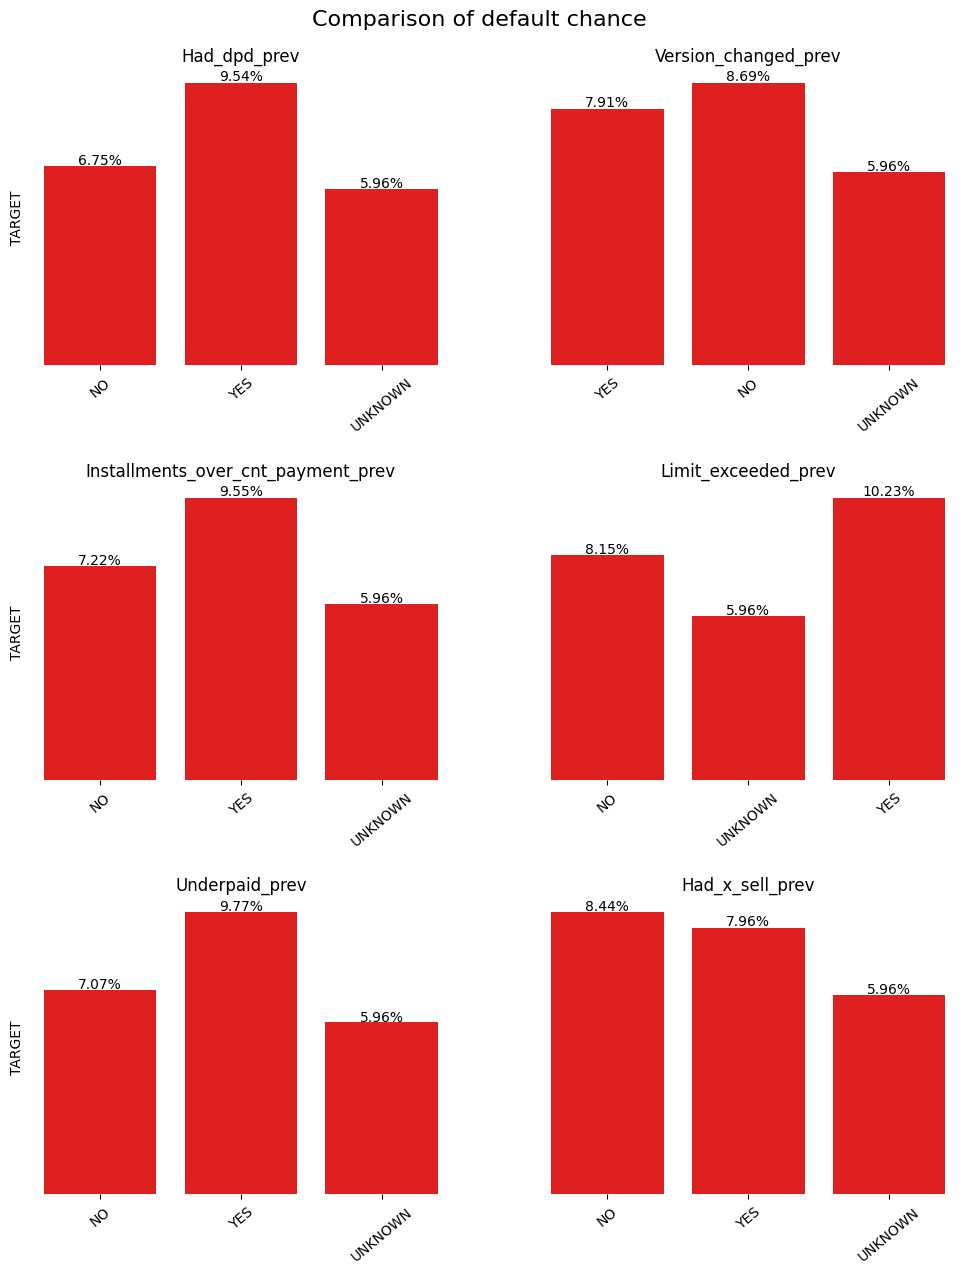

In [54]:
cols = ["HAD_DPD_PREV", "VERSION_CHANGED_PREV", "INSTALLMENTS_OVER_CNT_PAYMENT_PREV",
        "LIMIT_EXCEEDED_PREV", "UNDERPAID_PREV", "HAD_X_SELL_PREV"]
helper_functions.plot_cat_columns(application_agg, cols, col_number=2,
                                   title=title, figsize=(12, 20), rotate=40, 
                                   target="TARGET");

We see that client's history plays some role in the default chance. People, who had history of paying late, paying less than required, using more money than allowed had higher chance of default. 

**Analysis of the following numeric columns**:
* average interest rate
* average down payment
* average amount of credit

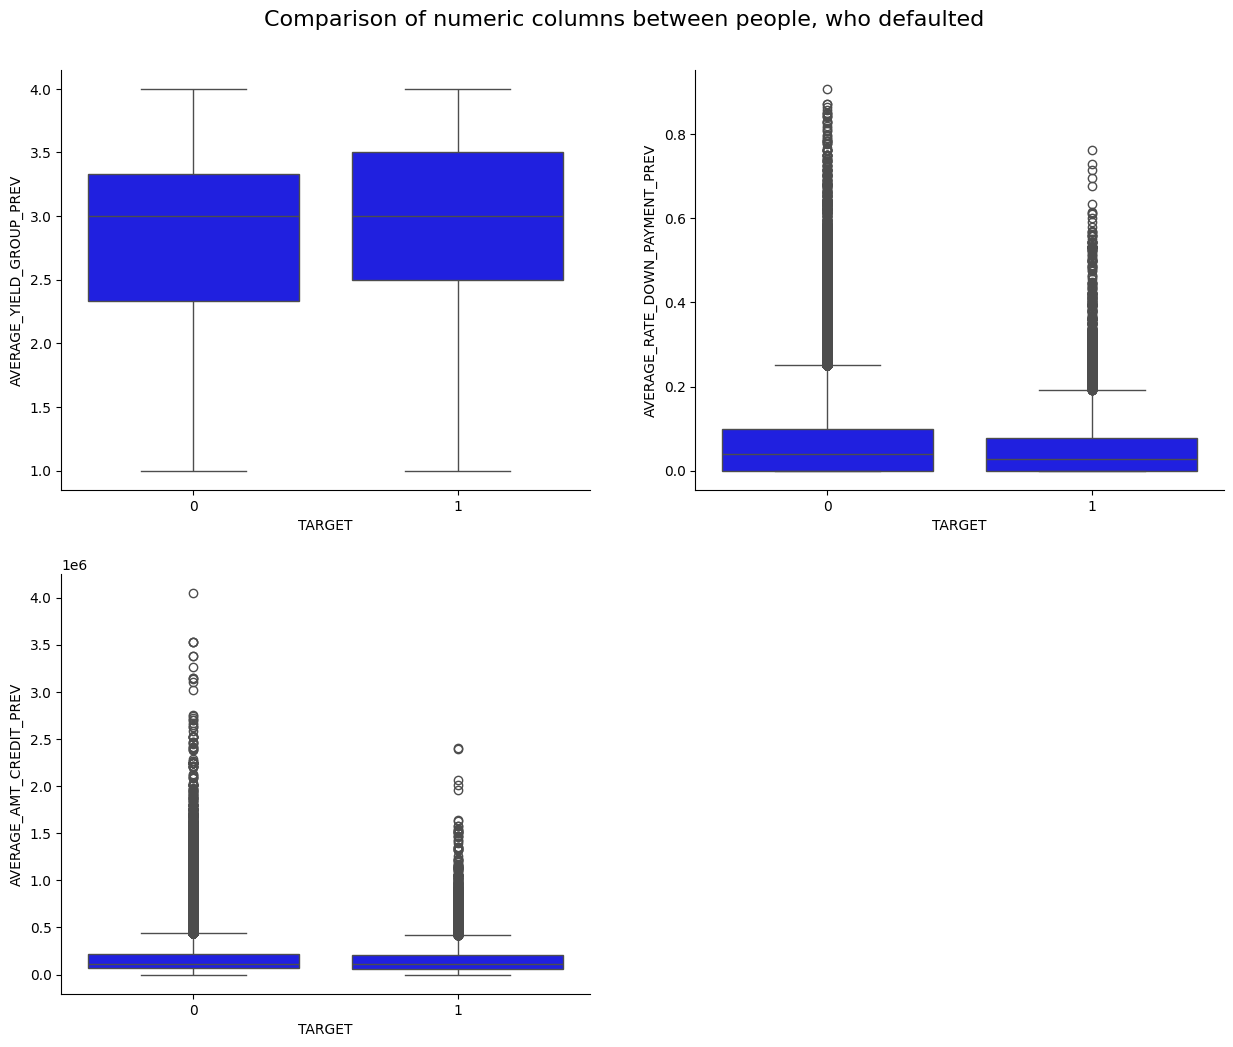

In [55]:
loan_info_cols = ["AVERAGE_YIELD_GROUP_PREV", 
                  "AVERAGE_RATE_DOWN_PAYMENT_PREV", 
                  "AVERAGE_AMT_CREDIT_PREV"]
title = "Comparison of numeric columns between people, who defaulted"
helper_functions.plot_num_dist(columns=loan_info_cols, 
                               data=application_agg, 
                               figsize=(15, 12), 
                               title=title,
                               plot_type="box",
                               hue="TARGET");

Average interest rate in previous application is a bit higher for people, who defaulted

**Analysing of historical numeric columns:**
* Average number of installments
* Average number of planned payments
* Average amount of installment
* Average amount of drawings
* Total number of days past dues

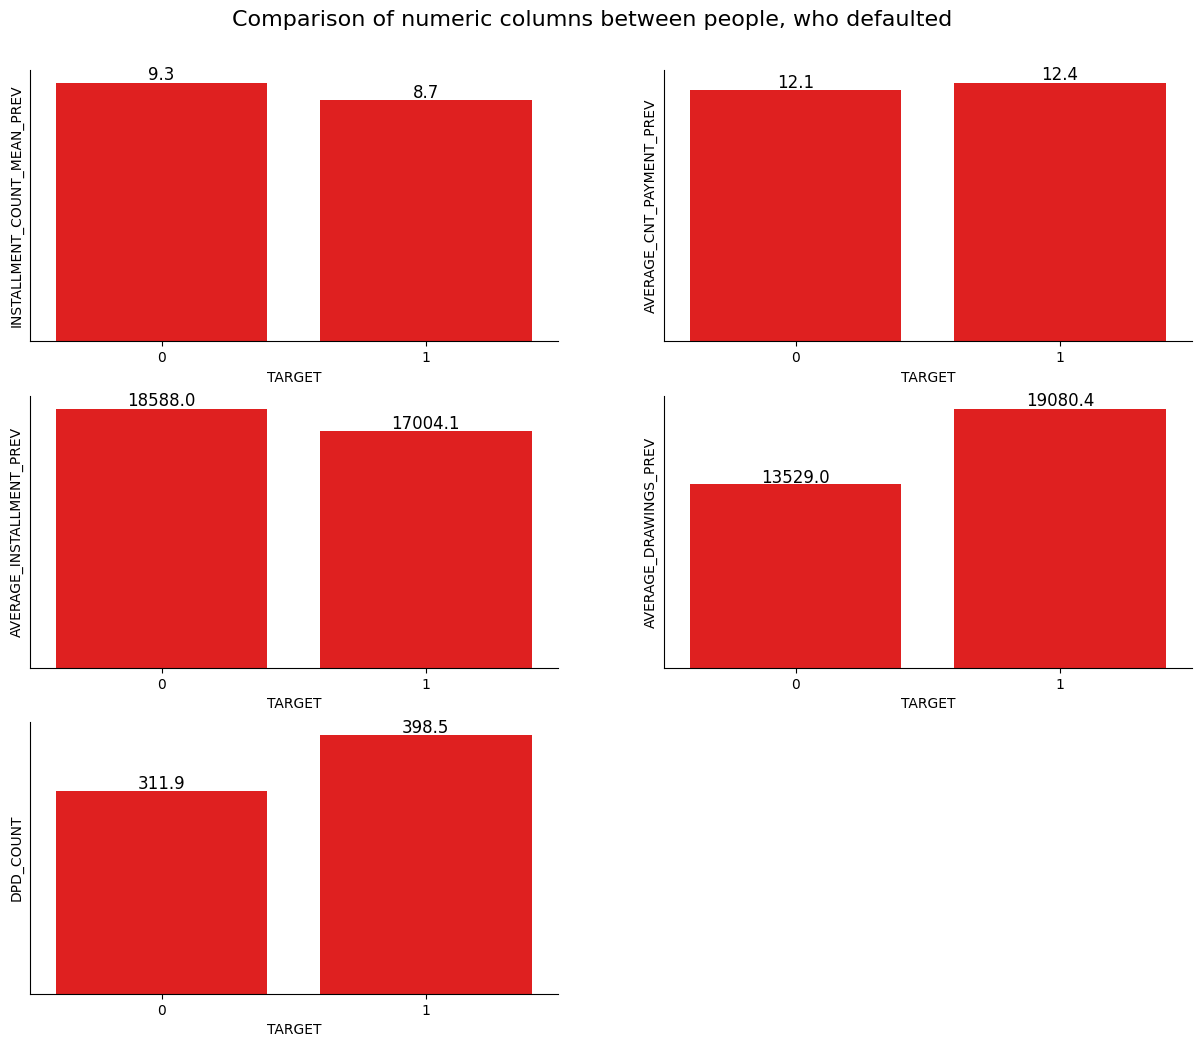

In [58]:
loan_history_cols = ["INSTALLMENT_COUNT_MEAN_PREV",
                    "AVERAGE_CNT_PAYMENT_PREV", "AVERAGE_INSTALLMENT_PREV",
                    "AVERAGE_DRAWINGS_PREV", "DPD_COUNT"]
title = "Comparison of numeric columns between people, who defaulted"
helper_functions.plot_num_dist(columns=loan_history_cols,
                               data=application_agg, 
                               figsize=(15, 12), 
                               title=title,
                              plot_type="bar",
                              hue="TARGET");

People, who defaulted, drawed more money on average. In addition, defaulted people had shorter loans. Defaulted people also have more days past due on average

**Analysis of columns related to time**:
* Most recent appearance of the client's loan
* Average of the recent apperances of the client's loans
* Average of the days when the decision about the application was made
* Day of the most recently created loan
* Average months of all previous loans
* Average length of loans

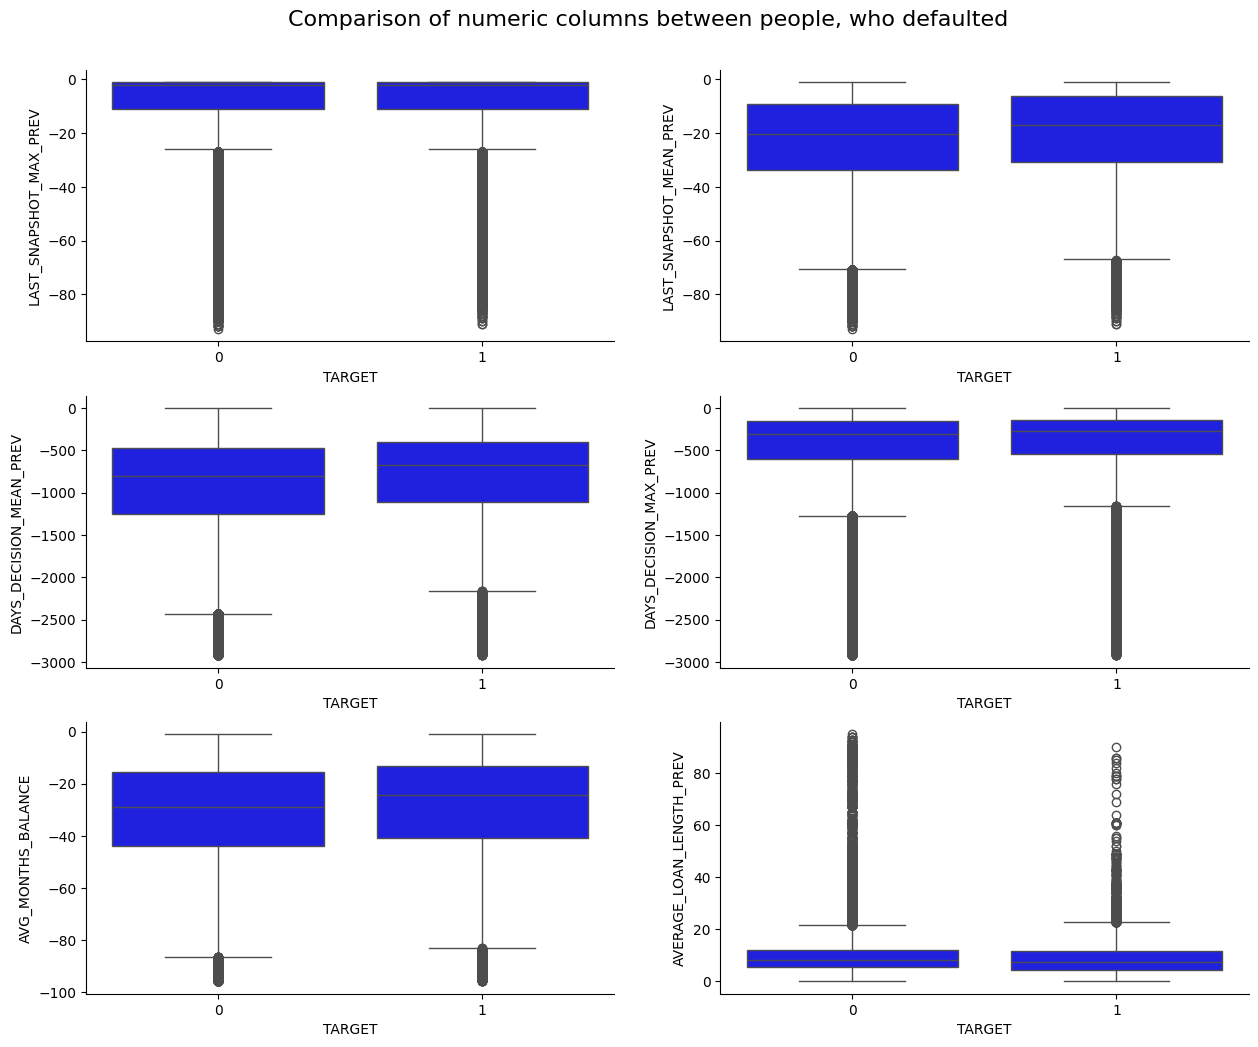

In [59]:
loan_time_cols = ["LAST_SNAPSHOT_MAX_PREV", "LAST_SNAPSHOT_MEAN_PREV",
                 "DAYS_DECISION_MEAN_PREV", "DAYS_DECISION_MAX_PREV",
                 "AVG_MONTHS_BALANCE", "AVERAGE_LOAN_LENGTH_PREV"]
title = "Comparison of numeric columns between people, who defaulted"
helper_functions.plot_num_dist(columns=loan_time_cols,
                               data=application_agg, 
                               figsize=(15, 12), 
                               title=title,
                              plot_type="box",
                              hue="TARGET");

There doesn't seem to be any association in time columns

Turn negative columns to positive, so that logarithmic transformation could be applied to these columns:

In [61]:
agg_prev["DAYS_DECISION_MAX_PREV"] = - agg_prev["DAYS_DECISION_MAX_PREV"]
agg_prev["DAYS_DECISION_MEAN_PREV"] = - agg_prev["DAYS_DECISION_MEAN_PREV"]
agg_prev["LAST_SNAPSHOT_MAX_PREV"] = - agg_prev["LAST_SNAPSHOT_MAX_PREV"]
agg_prev["LAST_SNAPSHOT_MEAN_PREV"] = - agg_prev["LAST_SNAPSHOT_MEAN_PREV"]
agg_prev["AVG_MONTHS_BALANCE"] = - agg_prev["AVG_MONTHS_BALANCE"]

In [62]:
agg_prev.to_csv("previous_applications_agg_features.csv")

## Conclusion from the Analysis of Features from Previous Applications

In total, we analyzed over **1.6 million previous applications**, with most of them containing historical data on loan situations across multiple months. While many columns had significant missing values, the final aggregated features provided valuable insights. A large proportion of applications were not approved. After aggregating the data on a client level, we derived the following key insights:

1. **Default Rate and Loan History**:
    * Past Loan History: Clients who have taken loans in the past tend to have a higher default rate compared to those without previous loans.
    * Number of Previous Applications: An increase in the average number of previous applications correlates with a higher chance of default. This suggests that frequent loan applicants may have financial difficulties leading to higher default rates.
2. **Impact of Unapproved Loans**
    * Clients who had unapproved loans in the past exhibit a lower chance of approval for future loans and are also more likely to default. This indicates that a history of loan rejection may be a strong negative predictor of future loan behavior.
3. **Ongoing Loans and Default Rates:**
    * Interestingly, clients with ongoing loans have a slightly lower chance of default. This may indicate that clients who are currently managing loans are more likely to continue managing their financial obligations responsibly.
4. **Type of Loan and Default Rates:**
    * Cash Loans and Revolving Loans: Having taken cash or revolving loans in the past was found to negatively affect the default rate. Clients with these types of loans tend to show lower default risk, possibly due to the flexibility and repayment terms associated with these products.
5. **Payment History as a Strong Predictor:**
    * Late Payments: Clients with a history of late payments show a higher likelihood of default. This suggests that payment behavior is a significant predictor of financial stability.
    * Underpaid Installments: Clients who paid less than the required minimum installment are also more likely to default in the future, emphasizing the importance of maintaining the agreed repayment schedule.
    * Exceeding Credit Limits: Clients who drew more money than their allowed limit on revolving loans are at a higher risk of default, indicating poor financial management.
6. **Interest Rates and Default Rate:**
    * Clients who took loans with higher interest rates in the past tend to have a higher default rate, which may indicate that higher-cost loans are associated with financially unstable clients.
7. **Days Past Due (DPD)**
    * People who defaulted tend to have more days past due in their previous loans. This reflects poor repayment behavior and suggests that clients with high DPD are more likely to default in the future.
8. **Average Drawn Amount**
    * Clients who drew more money on average from their loans are more likely to default. This may indicate that higher loan amounts are associated with clients who overextend themselves financially.